<a href="https://colab.research.google.com/github/CHENHUI-X/Segmentation_models_pytorch_eg/blob/main/Segmentation_models_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- An example for segmentation used model that names `Segmentation_models_pytorch`

 - See link for details : https://blog.paperspace.com/image-segmentation-using-segmentation_models_pytorch/

----

# 1 Download data from kaggle

1. Get a Kaggle account

2. Create an API token by going to your Account settings, and save kaggle.json to your local computer. Note: you may need to create a new api token if you have already created one.

3. Upload kaggle.json to your  Notebook


4. run the following commands in a terminal (this may take a while)

```bash
mkdir ~/.kaggle/

mv kaggle.json ~/.kaggle/

pip install kaggle

kaggle datasets download tapakah68/supervisely-filtered-segmentation-person-dataset

unzip supervisely-filtered-segmentation-person-dataset.zip


```


run the code

In [9]:
!mkdir ~/.kaggle/

!mv kaggle.json ~/.kaggle/

!pip install kaggle

!kaggle datasets download tapakah68/supervisely-filtered-segmentation-person-dataset

!unzip supervisely-filtered-segmentation-person-dataset.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: supervisely_person_clean_2667_img/images/ds2_person-human-female-girl.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_person-woman-coffee-cup.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_person-woman-eyes-face.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_person-woman-hotel-laptop.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_pexels-photo-105472.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_pexels-photo-123318.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_pexels-photo-125522.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_pexels-photo-12628.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_pexels-photo-127901.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_pexels-photo-134068.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_pexels-photo-136673.png  
  inflating: supervisely_person_

# 2 Load all dependencies we need

In [2]:
!pip install segmentation_models_pytorch 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 7.1 MB/s 
     |████████████████████████████████| 58 kB 7.0 MB/s 
     |████████████████████████████████| 376 kB 57.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=15377a354e534a7ffa1497b4405f58903380ae42f4b2863886ac3e0a32da04a5
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=65e500f8fc7ab78ffcb56fd3e7aaeded473453068262e6c0bf08c3ca926e8233
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
import os
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import segmentation_models_pytorch as smp

import albumentations as A  
from albumentations.pytorch import ToTensorV2
# https://zhuanlan.zhihu.com/p/147594227

from tqdm import tqdm
import matplotlib.pyplot as plt

# 3 Seed everything 

In [4]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

# 4 Defined dataset 

In [5]:
class SegmentationDataset(Dataset):
    def __init__(self, input_dir, output_dir, is_train, transform=None):
        self.input_dir  = input_dir
        self.output_dir = output_dir
        self.transform  = transform
        train_size = round(len(os.listdir(input_dir)) * .8)

        if is_train == True:
            self.images = os.listdir(input_dir)[:train_size]
        else: 
            self.images = os.listdir(input_dir)[train_size:]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path    = os.path.join(self.input_dir, self.images[index])
        mask_path   = os.path.join(self.output_dir, self.images[index]) # 黑白图片
        img         = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32) / 255
        mask        = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)   / 255
        # Convert("L") 为灰度图像，每个像素用8个bit表示，0表示黑，255表示白，其他数字表示不同的灰度。
        # See convert function for details https://www.cnblogs.com/haifwu/p/12825741.html  
        
        if self.transform is not None:
            
            augmentations = self.transform(image=img, mask=mask)
            img   = augmentations["image"]
            mask  = augmentations["mask"] # 使用黑白0 1值mask图片，返回一个mask版本
        
        return img, mask # input and ouput 

# 5 Hyperparameters and Initializations

Let's initialize train_inp_dir by the path of the images, train_out_dir by the path of the masks, and device by Cuda if it is available and CPU otherwise. Set up some hyperparameters (learning rate, batch size, number of epochs...). Finally, initialize transforms for training that contains resize images and some augmentations (horizontal flip and color jitter), and convert them to tensors. It is the same process for validation, except for augmentations.

In [32]:
TRAIN_INP_DIR = './supervisely_person_clean_2667_img/images/'
TRAIN_OUT_DIR = './supervisely_person_clean_2667_img/masks/'
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

LEARNING_RATE = 3e-4
BATCH_SIZE    = 64
NUM_EPOCHS    = 10
IMAGE_HEIGHT  = 256  
IMAGE_WIDTH   = 192  

# A : the module 'albumentations'
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.ColorJitter(p=0.2),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2(),
    ],
)

# 6 Defined get loader function 

In [7]:
def get_loaders( inp_dir, mask_dir,batch_size,
			     train_transform, val_tranform ):
    
    train_ds     = SegmentationDataset( input_dir=inp_dir, output_dir=mask_dir,
                            is_train=True, transform=train_transform)

    train_loader = DataLoader( train_ds, batch_size=batch_size, shuffle=True )

    val_ds       = SegmentationDataset( input_dir=inp_dir, output_dir=mask_dir,
                            is_train=False, transform=val_transform)

    val_loader   = DataLoader( val_ds, batch_size=batch_size, shuffle=True  )

    return train_loader, val_loader

# 7 Check Data loader

In [20]:
train_loader, val_loader = get_loaders( TRAIN_INP_DIR, TRAIN_OUT_DIR,
                            BATCH_SIZE,  train_transform, val_transform)


In [ ]:
inputs, masks = next(iter(train_loader))

_, ax = plt.subplots(1,2)
ax[0].imshow(inputs[0].permute(1,2,0))
ax[1].imshow(masks[0])

# 8 Defined Check accuracy function 

In [17]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels  = 0
    dice_score  = 0
    model.eval()

    with torch.no_grad():
        for img, mask in tqdm(loader):
            img   = img.to(device)
            mask  = mask.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(img))
            preds = (preds > 0.5).float()
            num_correct += (preds == mask).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * mask).sum()) / (
                (preds + mask).sum() + 1e-7
            )

    print(
        f"Got {num_correct}/{num_pixels} with pixel accuracy {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)*100:.2f}")
    model.train()

# 9 Model, loss function, and optimizer

- We will build such a powerful model with just one line of code using Segmentation_models_pytorch, we chose the legendary UNet architecture with transfer learning 'efficientnet-b3', with number of input 3 (RGB), number of classes 1, without using any activation function. But before using the predictions, we use sigmoid to have the pixels between 1 and 0. lastly, we move the model to the device.


- We have a binary class segmentation, so basically, it's just a binary classification task at the pixel level, so in the loss function, we will use BCEWithLogitsLoss.


- For the optimizer, we will use Adam.

In [12]:
model = smp.Unet(encoder_name='efficientnet-b3', in_channels=3, classes=1, activation=None).to(DEVICE)
loss_fn   = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

# 10 Training

In [13]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader,desc="进度条")

    for batch_idx, (image, mask) in enumerate(loop):
        image   = image.to(device=DEVICE)
        mask    = mask.float().unsqueeze(1).to(device=DEVICE)

        # forward
        predictions = model(image)
        loss = loss_fn(predictions, mask)

        # backward
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix({'loss' : '{0:1.5f}'.format(loss.item())})#输入一个字典，显示实验指标

# from collections import OrderedDict
 
# total = 10000 #总迭代次数
# loss = total
# with tqdm(total=total, desc="进度条") as pbar:
#     for i  in range(total):
#         loss -= 1 
# #        pbar.set_postfix(OrderedDict(loss='{0:1.5f}'.format(loss)))
#         pbar.set_postfix({'loss' : '{0:1.5f}'.format(loss)}) #输入一个字典，显示实验指标
#         pbar.update(1)

In [ ]:
for epoch in range(NUM_EPOCHS):

    print('------------------ epoch: '+str(epoch) ------------------)
    train_fn(train_loader, model, optimizer, loss_fn)
    
    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)


# 11 Visualize results

Now the moment of the truth, let's visualize the results and compare them with the ground truth.

IndexError: ignored

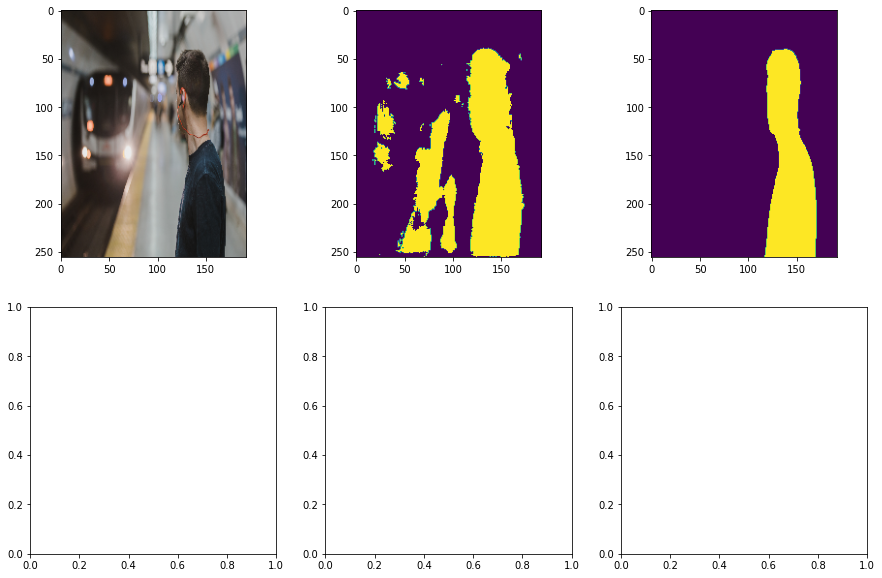

In [35]:
inputs, masks = next(iter(val_loader))
output        = ((torch.sigmoid(model(inputs.to(DEVICE)))) >0.5).float()
_, ax = plt.subplots(2,3, figsize=(15,10))
for k in range(2):
    ax[k][0].imshow(inputs[k].permute(1,2,0))
    ax[k][1].imshow(output[k][0].cpu()) # the prediction
    ax[k][2].imshow(masks[k]) # the true